In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.feature_selection import SelectKBest,chi2

In [2]:
df = pd.read_csv('/content/kidney_disease.csv')
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
df.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [4]:
df['pcv'] = np.where(df['pcv']=='\t?','',df['pcv'])
df['wc'] = np.where(df['wc']=='\t?','',df['wc'])
df['rc'] = np.where(df['rc']=='\t?','',df['rc'])

In [5]:
df['pcv'] = pd.to_numeric(df['pcv'])
df['wc'] = pd.to_numeric(df['wc'])
df['rc'] = pd.to_numeric(df['rc'])

In [6]:
categories = [x for x in df.columns if df[x].dtypes=='O']
categories

['rbc',
 'pc',
 'pcc',
 'ba',
 'htn',
 'dm',
 'cad',
 'appet',
 'pe',
 'ane',
 'classification']

In [7]:
for i in categories:
  df[i] = np.where(df[i].isnull(),mode(df[i]),df[i])

df.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc                 0
pc                  0
pcc                 0
ba                  0
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                71
wc                106
rc                131
htn                 0
dm                  0
cad                 0
appet               0
pe                  0
ane                 0
classification      0
dtype: int64

In [8]:
for i in df.columns :
  if i not in categories:
    df[i] = np.where(df[i].isnull(),df[i].mean(),df[i])
  else:
    pass

df.isnull().sum()

id                0
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

In [9]:
df.head()
# age', 'wc', 'bu', 'appet', 'bgr', 'pcc', 'htn', 'ane', 'pcv', 'bp'
# appet , pcc , htn , ane , 

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0.0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.000000,36.0,1.2,137.528754,4.627244,15.4,44.0,7800.0,5.200000,yes,yes,no,good,no,no,ckd
1,1.0,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,148.036517,18.0,0.8,137.528754,4.627244,11.3,38.0,6000.0,4.707435,no,no,no,good,no,no,ckd
2,2.0,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.000000,53.0,1.8,137.528754,4.627244,9.6,31.0,7500.0,4.707435,no,yes,no,poor,no,yes,ckd
3,3.0,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,yes,no,no,poor,yes,yes,ckd
4,4.0,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.000000,26.0,1.4,137.528754,4.627244,11.6,35.0,7300.0,4.600000,no,no,no,good,no,no,ckd


In [10]:
df['ane'].unique()

array(['no', 'yes'], dtype=object)

In [11]:
# 0 -> disease
# 1 -> no disease

# handling categorical variables
for i in categories:
  df[i] = pd.get_dummies(df[i],drop_first=True)

df = df.drop('id',axis=1)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.000000,36.0,1.2,137.528754,4.627244,15.4,44.0,7800.0,5.200000,1,0,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,148.036517,18.0,0.8,137.528754,4.627244,11.3,38.0,6000.0,4.707435,0,0,1,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,53.0,1.8,137.528754,4.627244,9.6,31.0,7500.0,4.707435,0,0,1,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,1,0,1,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,26.0,1.4,137.528754,4.627244,11.6,35.0,7300.0,4.600000,0,0,1,0,0,0,0


In [12]:
x = df.drop('classification',axis=1)
y = df['classification']

In [13]:
x.shape

(400, 24)

In [14]:
# feature selection

selection = SelectKBest(chi2,k=24)
selection.fit(x,y)
selection.scores_

array([1.13054201e+01, 1.10003141e+00, 2.71047733e-05, 4.77528887e-01,
       2.26202236e-01, 3.14461828e-02, 2.38476332e-01, 2.98683896e+00,
       1.10552764e-01, 3.68028544e+00, 9.44385646e+00, 1.78573952e-01,
       6.01550625e-02, 7.03325523e-03, 3.20477781e-01, 1.53104258e+00,
       1.01592533e+01, 5.20161762e-01, 2.18811746e+00, 1.00502513e-02,
       1.78916561e-02, 6.19708298e+00, 3.81909548e-01, 1.64154104e+00])

In [15]:
scores = pd.DataFrame(selection.scores_,columns=['scores'])
columns = pd.DataFrame(x.columns,columns=['columns'])
scores['columns'] = columns
scores

,scores,columns
0,11.305420,age
1,1.100031,bp
2,0.000027,sg
3,0.477529,al
4,0.226202,su
5,0.031446,rbc
6,0.238476,pc
7,2.986839,pcc
8,0.110553,ba
9,3.680285,bgr


In [16]:
final = scores.nlargest(10,'scores')
final = list(final['columns'].to_numpy())
final

# age - age
# bp - blood pressure
# sg - specific gravity
# al - albumin
# su - sugar
# rbc - red blood cells
# pc - pus cell
# pcc - pus cell clumps
# ba - bacteria
# bgr - blood glucose random
# bu - blood urea
# sc - serum creatinine
# sod - sodium
# pot - potassium
# hemo - hemoglobin
# pcv - packed cell volume
# wc - white blood cell count
# rc - red blood cell count
# htn - hypertension
# dm - diabetes mellitus
# cad - coronary artery disease
# appet - appetite
# pe - pedal edema
# ane - anemia


['age', 'wc', 'bu', 'appet', 'bgr', 'pcc', 'htn', 'ane', 'pcv', 'bp']

In [17]:
x = x[final]
x

,age,wc,bu,appet,bgr,pcc,htn,ane,pcv,bp
0,48.0,7800.0,36.0,0,121.000000,0,1,0,44.0,80.0
1,7.0,6000.0,18.0,0,148.036517,0,0,0,38.0,50.0
2,62.0,7500.0,53.0,1,423.000000,0,0,1,31.0,80.0
3,48.0,6700.0,56.0,1,117.000000,1,1,1,32.0,70.0
4,51.0,7300.0,26.0,0,106.000000,0,0,0,35.0,80.0
...,...,...,...,...,...,...,...,...,...,...
395,55.0,6700.0,49.0,0,140.000000,0,0,0,47.0,80.0
396,42.0,7800.0,31.0,0,75.000000,0,0,0,54.0,70.0
397,12.0,6600.0,26.0,0,100.000000,0,0,0,49.0,80.0
398,17.0,7200.0,50.0,0,114.000000,0,0,0,51.0,60.0


In [18]:
# feature scaling
scaler = StandardScaler()
scaling = scaler.fit_transform(x)
scaling

array([[-0.20546364, -0.24051868, -0.43526769, ..., -0.42008403,
         0.62837158,  0.26233836],
       [-2.62380991, -0.95478626, -0.80094118, ..., -0.42008403,
        -0.10864892, -1.96658024],
       [ 0.62031314, -0.35956327, -0.0899094 , ...,  2.38047614,
        -0.96850617,  0.26233836],
       ...,
       [-2.32888964, -0.71669706, -0.63841963, ..., -0.42008403,
         1.24255533,  0.26233836],
       [-2.03396936, -0.47860787, -0.15085498, ..., -0.42008403,
         1.48822884, -1.22360737],
       [ 0.38437691, -0.637334  , -0.80094118, ..., -0.42008403,
         1.73390234,  0.26233836]])

In [19]:
x = pd.DataFrame(scaling,columns = x.columns)
x.head()

,age,wc,bu,appet,bgr,pcc,htn,ane,pcv,bp
0,-0.205464,-0.240519,-0.435268,-0.507801,-0.361987,-0.342518,1.311903,-0.420084,0.628372,0.262338
1,-2.623810,-0.954786,-0.800941,-0.507801,0.000000,-0.342518,-0.762252,-0.420084,-0.108649,-1.966580
2,0.620313,-0.359563,-0.089909,1.969276,3.681441,-0.342518,-0.762252,2.380476,-0.968506,0.262338
3,-0.205464,-0.677016,-0.028964,1.969276,-0.415543,2.919556,1.311903,2.380476,-0.845669,-0.480635
4,-0.028511,-0.438926,-0.638420,-0.507801,-0.562820,-0.342518,-0.762252,-0.420084,-0.477159,0.262338


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


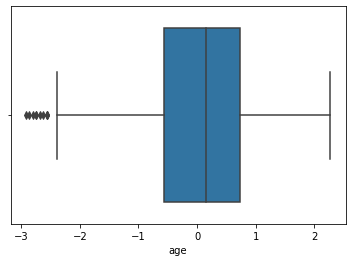

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


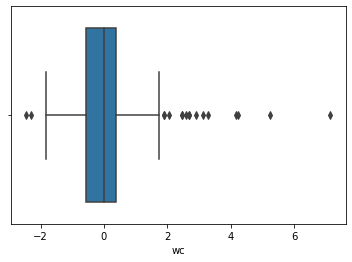

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


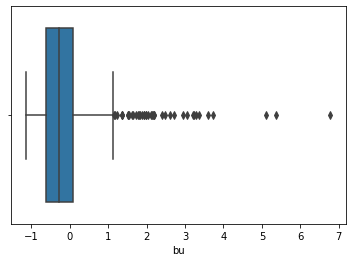

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


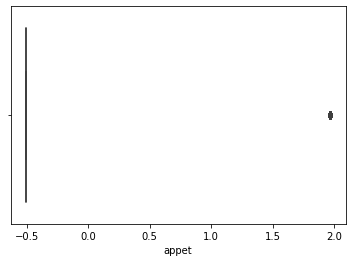

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


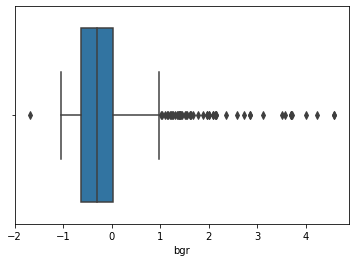

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


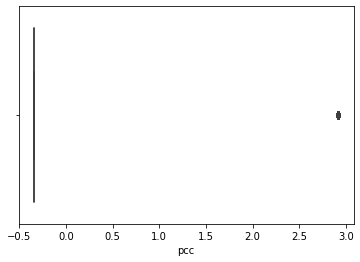

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


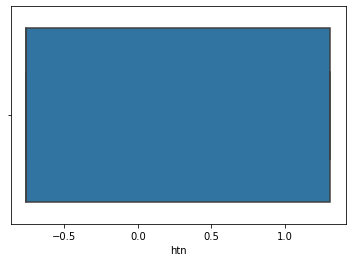

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


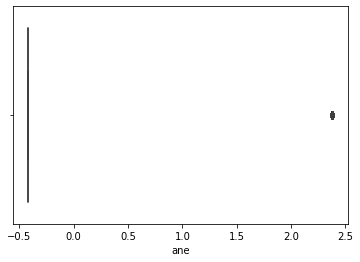

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


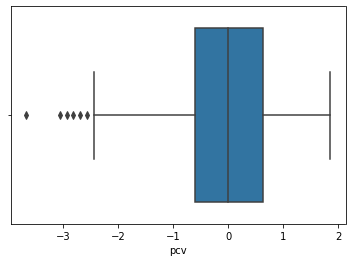

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


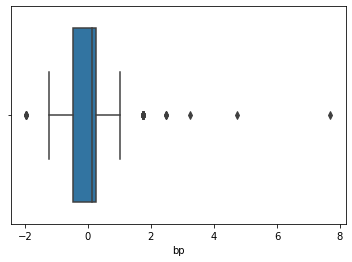

In [20]:
for i in x.columns:
  sns.boxplot(x[i])
  plt.show()

In [21]:
# handling outliers

for i in x.columns:
  q1 = np.percentile(x[i],25)
  q3 = np.percentile(x[i],75)
  iqr = q3-q1
  upper_bound = q3+(1.5*iqr)
  lower_bound = q1-(1.5*iqr)

  x[i] = np.where(x[i]>upper_bound,upper_bound,x[i])
  x[i] = np.where(x[i]<lower_bound,lower_bound,x[i])
    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


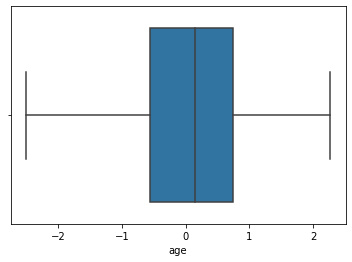

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


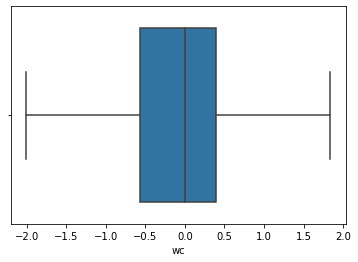

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


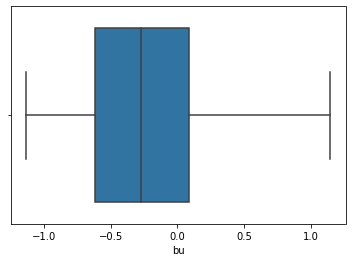

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


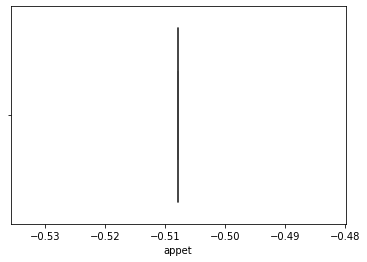

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


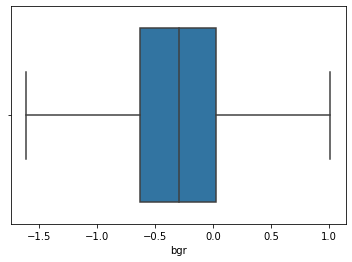

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


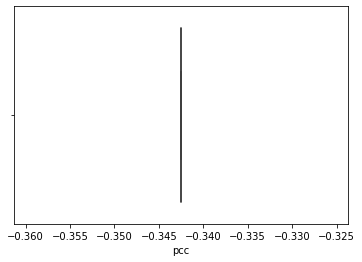

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


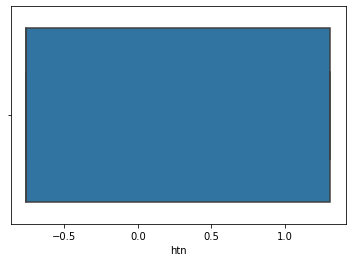

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


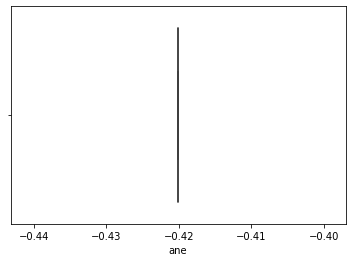

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


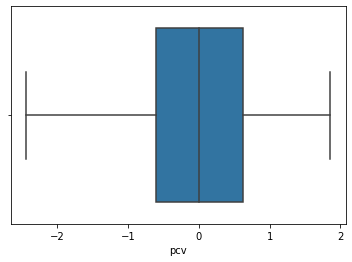

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


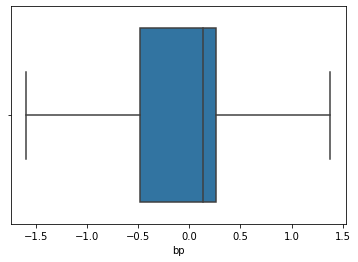

In [22]:
for i in x.columns:
  sns.boxplot(x[i])
  plt.show()

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size = 0.8,random_state=42)

In [24]:
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = KNeighborsClassifier()
model4 = SVC()
model5 = XGBClassifier()

In [25]:
model1.fit(x_train,y_train)
pred = model1.predict(x_test)
print(accuracy_score(y_test,pred))

1.0


In [26]:
model2.fit(x_train,y_train)
pred = model2.predict(x_test)
print(accuracy_score(y_test,pred))

1.0


In [27]:
model3.fit(x_train,y_train)
pred = model3.predict(x_test)
print(accuracy_score(y_test,pred))

1.0


In [28]:
model4.fit(x_train,y_train)
pred = model4.predict(x_test)
print(accuracy_score(y_test,pred))

1.0


In [29]:
model5.fit(x_train,y_train)
pred = model5.predict(x_test)
print(accuracy_score(y_test,pred))

1.0


In [30]:
model2.predict([[0.620313,-0.359563,-0.089909,1.969276,3.681441,-0.342518,-0.762252,2.380476,-0.968506,0.262338]])

array([0], dtype=uint8)

In [31]:
## here we are taking random forest model

In [32]:
import pickle
pickle.dump(model2,open('kidney_disease.pkl','wb'))